In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
import numpy as np
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [2]:
train_directory = 'Downloads/places/seg_train/seg_train'
val_directory = 'Downloads/places/seg_test/seg_test'
test_directory = 'Downloads/places/seg_pred'

In [3]:
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2
                                            )

In [4]:
train_dataset = data_aug.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),
    subset="training",
    seed=42,
    batch_size=32 )

val_dataset = data_aug.flow_from_directory(
    directory=val_directory,
    target_size=(224, 224),
    seed=42,
    batch_size=32 )
test_dataset = data_aug.flow_from_directory(
    directory=test_directory,
    target_size=(224, 224),
    subset="validation",
    seed=42,
    batch_size=32 )

Found 11230 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 1460 images belonging to 1 classes.


In [5]:
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
densenet = tf.keras.applications.DenseNet121(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet'
)

In [6]:
densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [7]:
densenet.trainable = False

In [8]:
model = Sequential()
model.add(densenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(640, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               656000    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3846      
Total params: 7,697,350
Trainable params: 659,846
Non-trainable params: 7,037,504
_________________________________________________________________


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
            loss='CategoricalCrossentropy',
            metrics = ['accuracy'])

In [10]:
history = model.fit(train_dataset , validation_data = val_dataset , epochs = 5)

Epoch 1/5
351/351 [==============================] - 1536s 4s/step - loss: 0.3978 - accuracy: 0.8523 - val_loss: 0.3440 - val_accuracy: 0.8723
Epoch 2/5
351/351 [==============================] - 1537s 4s/step - loss: 0.3166 - accuracy: 0.8839 - val_loss: 0.3510 - val_accuracy: 0.8620
Epoch 3/5
351/351 [==============================] - 1612s 5s/step - loss: 0.2925 - accuracy: 0.8903 - val_loss: 0.3008 - val_accuracy: 0.8923
Epoch 4/5
351/351 [==============================] - 1600s 5s/step - loss: 0.2693 - accuracy: 0.8995 - val_loss: 0.3044 - val_accuracy: 0.8837
Epoch 5/5
351/351 [==============================] - 1770s 5s/step - loss: 0.2616 - accuracy: 0.9046 - val_loss: 0.2848 - val_accuracy: 0.8923


In [11]:
for layer in densenet.layers[:416]:
    layer.trainable = None

In [12]:
model.compile(loss='CategoricalCrossentropy',
              optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [14]:
fine_tune_epochs = 2
total_epochs =  5 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 5/7
351/351 [==============================] - 1475s 4s/step - loss: 0.2105 - accuracy: 0.9213 - val_loss: 0.2519 - val_accuracy: 0.9040
Epoch 6/7
351/351 [==============================] - 1567s 4s/step - loss: 0.2048 - accuracy: 0.9240 - val_loss: 0.2333 - val_accuracy: 0.9080
Epoch 7/7
351/351 [==============================] - 1582s 4s/step - loss: 0.2041 - accuracy: 0.9249 - val_loss: 0.2510 - val_accuracy: 0.9093


In [15]:
predictions = model.predict(test_dataset)
print(predictions)

[[9.9992871e-01 7.0609714e-09 1.1097080e-07 2.8677857e-08 9.7806314e-08
  7.1053393e-05]
 [8.4526282e-06 1.3708207e-04 3.5835650e-02 9.5929897e-01 4.7190459e-03
  8.2590952e-07]
 [8.8319284e-05 2.5961066e-05 8.9145023e-01 1.0220707e-01 6.1538019e-03
  7.4682743e-05]
 ...
 [2.6140875e-05 1.0496037e-07 2.1296243e-07 1.1379127e-09 6.0700543e-08
  9.9997342e-01]
 [9.9959832e-01 1.8584891e-06 1.4402419e-05 1.0397190e-06 2.7665806e-06
  3.8163122e-04]
 [3.0684250e-03 9.9653244e-01 3.6966006e-04 5.5842929e-06 1.1880464e-06
  2.2728998e-05]]


In [16]:
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

[0 3 2 ... 5 0 1]


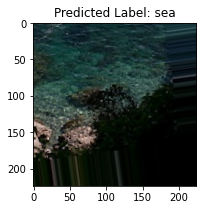

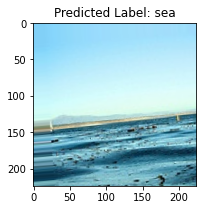

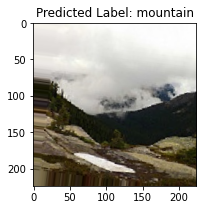

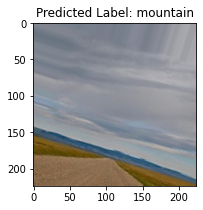

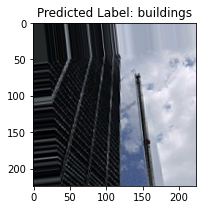

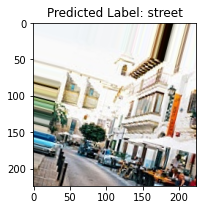

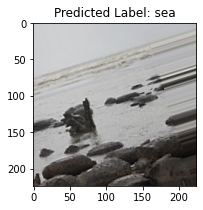

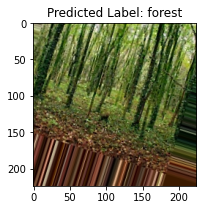

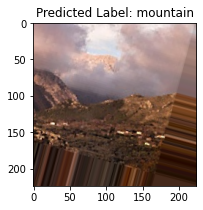

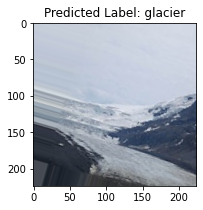

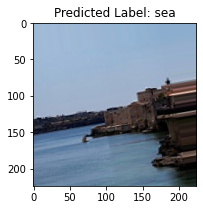

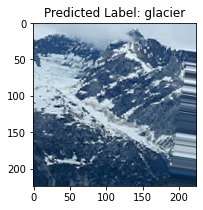

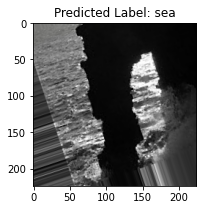

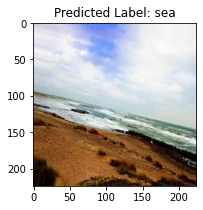

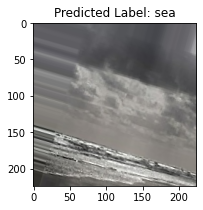

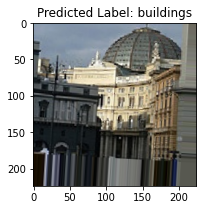

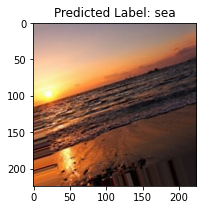

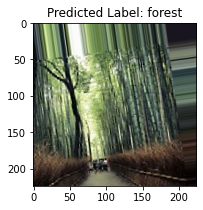

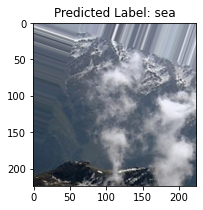

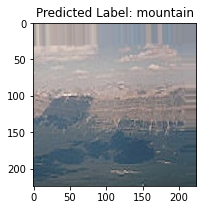

In [17]:
class_labels = ['buildings','forest','glacier','mountain','sea','street']  


for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    for i in range(min(20, len(images))):  
        plt.figure(figsize=(3, 3))
        plt.imshow(images[i])
        
        predicted_label = class_labels[predicted_labels[i]]
        
        plt.title(f"Predicted Label: {predicted_label}")
        plt.show()

    break  